In [196]:
using PyPlot, Statistics, ProfileView

to compile: `gfortran -w -shared -fPIC -g -std=legacy Voigt.f -o Voigt.so`

In [199]:
moogvoigt(x, σ, γ) = moogvoigt(γ/2σ, abs(x)/σ)
moogvoigt(α, v) = ccall((:voigt_, "./Voigt.so"), Float64, (Ptr{Float64}, Ptr{Float64}), [α], [v])

moogvoigt (generic function with 2 methods)

In [130]:
function harris_series(v) # assume v < 5
    H₀ = exp(-(v^2))
    H₁ = if (v < 1.3)
        -1.12470432 - 0.15516677v + 3.28867591v^2 - 2.34357915v^3 + 0.42139162v^4
        #-1.12470432 - 0.15516677*v + 3.28867591*v^2 - 2.34357915*v^3 + 0.42139162*v^4                                      
    elseif v < 2.4
        -4.48480194 + 9.39456063v - 6.61487486v^2 + 1.98919585v^3 - 0.22041650v^4
        #-4.48480194 + 9.39456063*v - 6.61487486*v^2 + 1.98919585*v^3 - 0.2204165*v^4                                               
    else #v < 5
        (0.554153432 + 0.278711796v - 0.188325687v^2 + 0.042991293v^3 - 0.003278278v^4) / (v^2 - 3/2)
        #(0.554153432 + 0.278711796*v - 0.188325687*v^2 + 0.042991293*v^3 - 0.003278278*v^4)/(v^2 - 1.5)
    end
    H₂ = (1 - 2v^2) * H₀
    H₀, H₁, H₂
end

lbvoigt(x, σ, γ) = lbvoigt(γ/2σ, abs(x)/σ)
function lbvoigt(α, v)
    if α <= 0.2 
        if (v >= 5)
            #!!!this line previously had "v" instead of "v^2"!!!
            (α / sqrt(π) / v^2) * (1 + 3/(2v^2) + 15/(4v^4))
        else
            H₀, H₁, H₂ = harris_series(v)
            H₀ + H₁*α + H₂*α^2
        end
    else  #unusual: α > 0.2
        if (α <= 1.4) && (α + v < 3.2)
            #modified harris series: M_i is H'_i in the source text
            H₀, H₁, H₂ = harris_series(v)
            M₀ = H₀
            M₁ = H₁ + 2/sqrt(π) * M₀
            M₂ = H₂ - M₀ + 2/sqrt(π) * M₁
            M₃ = 2/(3sqrt(π))*(1 - H₂) - 2/3 * v^2 * M₁ + 2/sqrt(π) * M₂
            M₄ = 2/3 * v^4 * M₀ - 2/(3sqrt(π)) * M₁ + 2/sqrt(π) * M₃
            ψ = 0.979895023 - 0.962846325α + 0.532770573α^2 - 0.122727278α^3
            ψ * (M₀ + M₁*α + M₂*α^2 + M₃*α^3 + M₄*α^4)
        else #α > 1.4 or (α > 0.2 and α + v > 3.2)
            u = sqrt(2) * (α^2 + v^2)
            sqrt(2/π) * (α/u) * (1 + (3v^2 - α^2)/u^2 + (15v^4 - 30α^2*v^2 + 2α^4)/u^4)
        end
    end
end
normlbvoigt(t...) = lbvoigt(t...) / sqrt(π)

normlbvoigt (generic function with 1 method)

In [4]:
using QuadGK

naivevoigt(α, v) = naivevoigt(v, 1., 2α)
function naivevoigt(x, σ, γ)
    integrand(y) = exp(-y^2/(2σ^2))/(σ * sqrt(2π)) * γ/(π * ((x-y)^2 + γ^2))
    integral, _ = quadgk(integrand, -Inf, Inf)
    integral
end

naivevoigt (generic function with 2 methods)

In [191]:
function plotvoigt(voigtf, αs = collect(10 .^ (-3:0.01:1)/2), vs = collect(0:0.01:10))
    Hs = Matrix{Float64}(undef, length(αs), length(vs))
    @time for i in 1:length(αs), j in 1:length(vs)
        Hs[i,j] = voigtf(αs[i], vs[j])
    end
    contour(2αs, vs, log.(Hs)', 50)
    xscale("log")
    xlim(1e-3, 10)
    gca().invert_xaxis()
    xlabel(L"2 \alpha")
    ylabel("v")
end
;

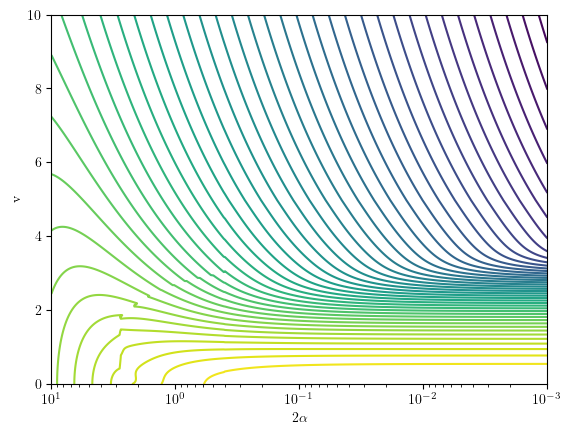

  0.019824 seconds


PyObject Text(22.29955098664297, 0.5, 'v')

In [194]:
plotvoigt(lbvoigt)

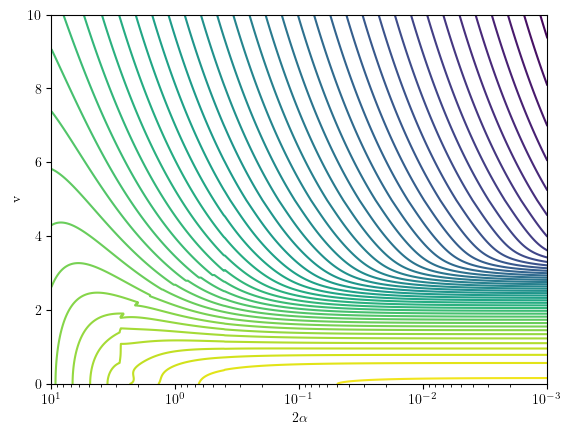

  0.136367 seconds (802.80 k allocations: 73.499 MiB)


PyObject Text(22.29955098664297, 0.5, 'v')

In [195]:
plotvoigt(moogvoigt)